   Life Ladder  Log GDP per capita  Social support  \
0        4.930               9.343           0.766   
1        5.367              10.299           0.901   
2        7.375              10.881           0.931   
3        4.613               7.554           0.724   
4        6.180              10.945             NaN   

   Healthy life expectancy at birth  Freedom to make life choices  Generosity  \
0                             64.22                           NaN      -0.127   
1                             67.48                         0.754      -0.201   
2                             72.60                         0.942       0.077   
3                             60.64                         0.702      -0.088   
4                             65.80                           NaN         NaN   

   Perceptions of corruption  Positive affect  Negative affect  
0                      0.709            0.669            0.331  
1                      0.726            0.702            0

<Figure size 1600x1200 with 0 Axes>

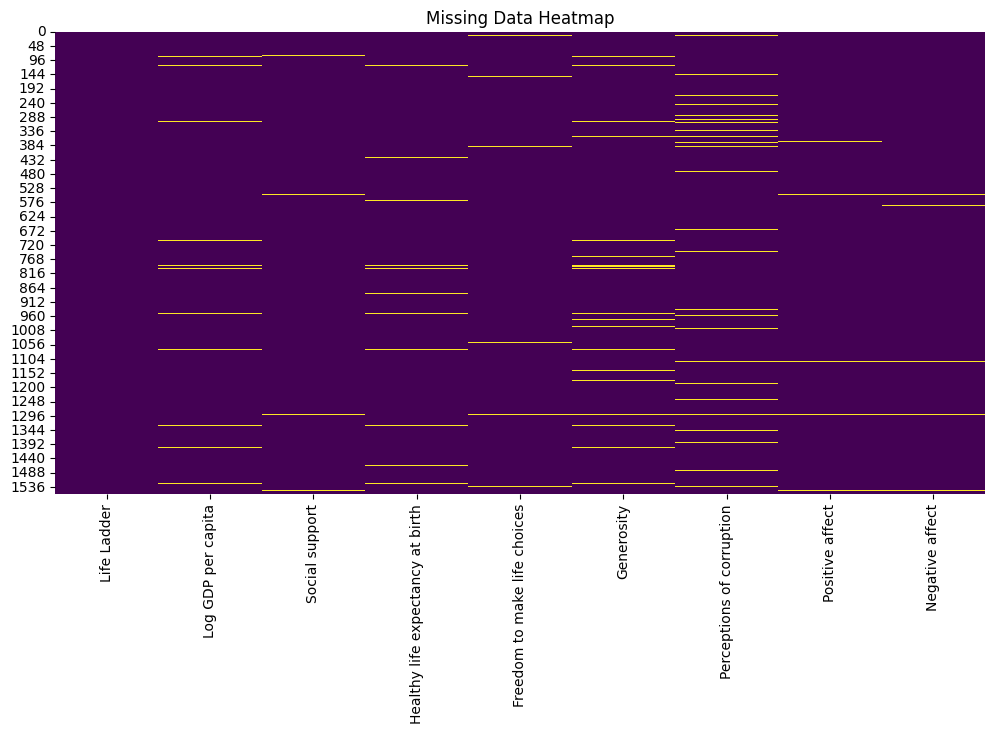


The dataset contains 1559 rows and 9 columns.

Categorical features: []
Continuous features: ['Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# Load your dataset
data = pd.read_csv('happiness_data_train.csv')  
print(data.head())
print(data.info())
print(data.describe())


plt.figure(figsize=(16, 12))

# Plot missing data heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

# Dataset summary
num_rows, num_cols = data.shape
print(f"\nThe dataset contains {num_rows} rows and {num_cols} columns.\n")

# Identify categorical vs continuous features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
continuous_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Continuous features:", continuous_features)



In [2]:
print(data.isnull().sum())
target_col = 'Life Ladder'
X = data.drop(columns=[target_col])
y = data[target_col]

Life Ladder                          0
Log GDP per capita                  26
Social support                      10
Healthy life expectancy at birth    37
Freedom to make life choices        22
Generosity                          71
Perceptions of corruption           86
Positive affect                     17
Negative affect                     14
dtype: int64


Anwer to question 1: 
------------------------------------------------------------------------------------------------------------------------------------------------------
1559 entries are present.
All the features are continuous and no attribute is categorical. Some of the the features like perception of corruption has more missing values than others.
------------------------------------------------------------------------------------------------------------------------------------------------------

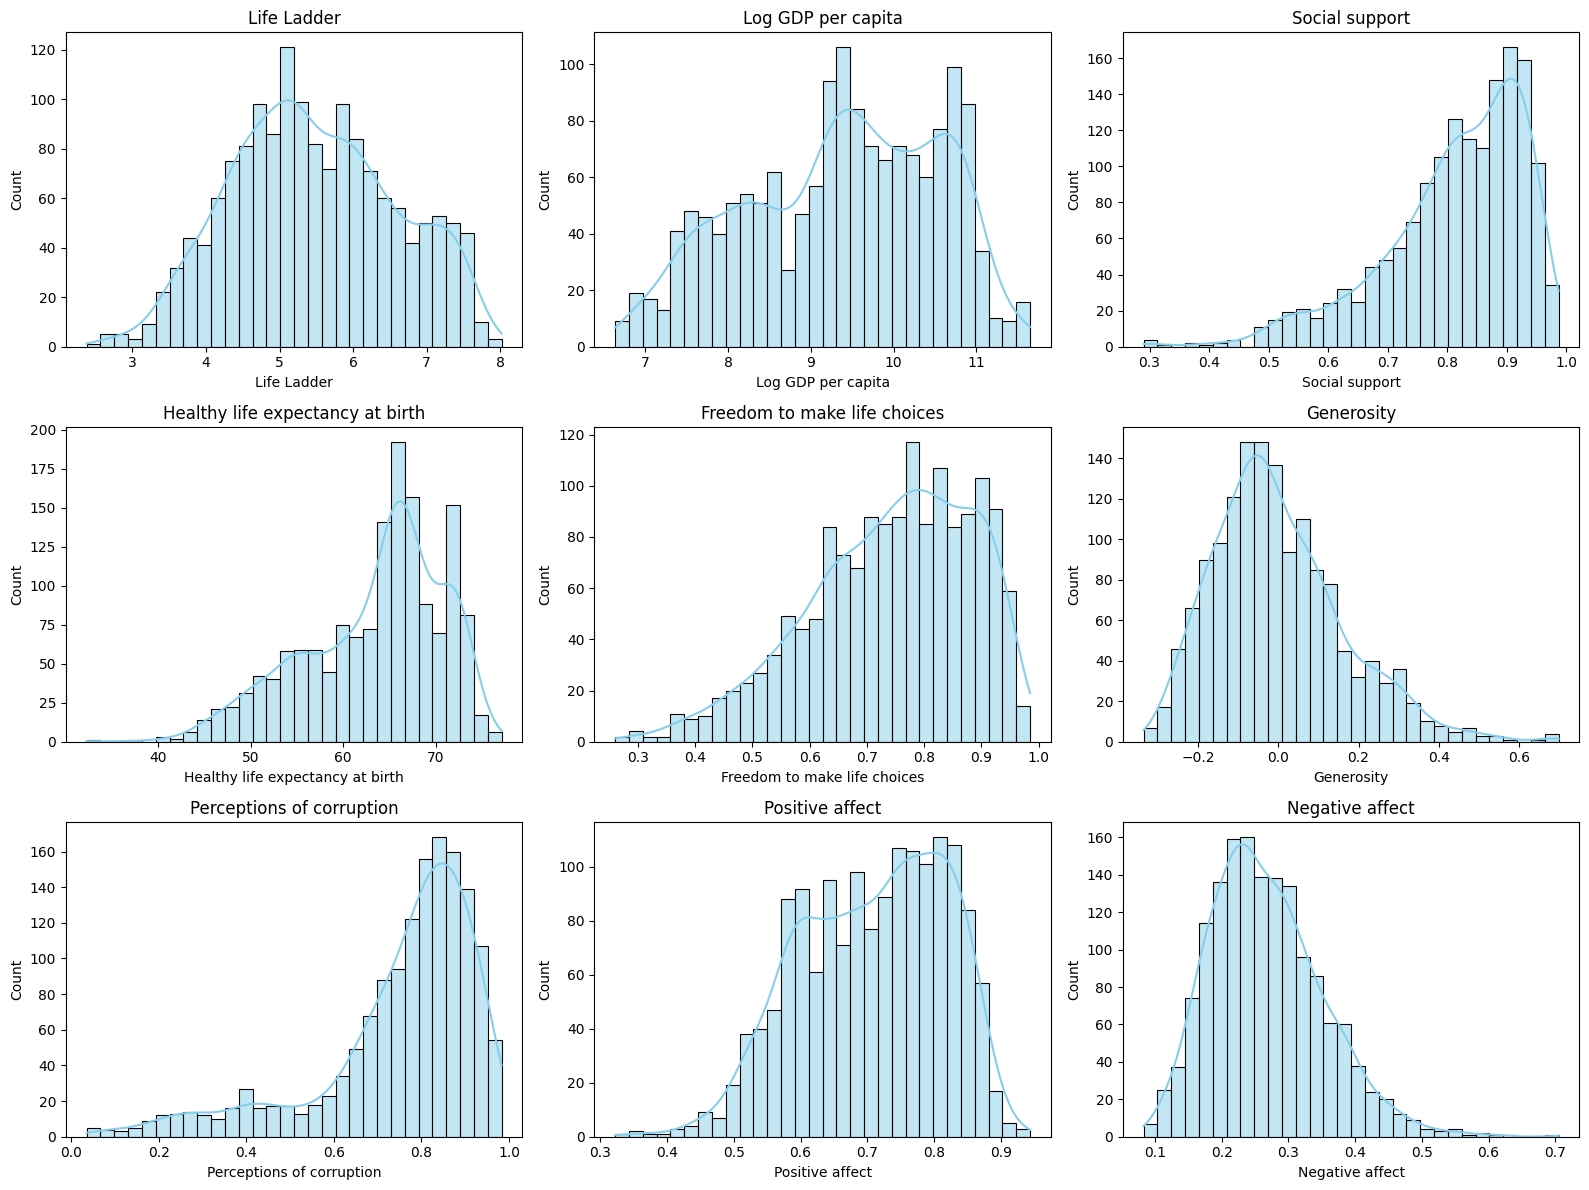

In [3]:
# Plot histograms for all continuous features
plt.figure(figsize=(16, 12))
for i, col in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

Answer to B
--------------------------------------------------------------------------------------
Require Special Treatment for:
Social support, Freedom to make life choices, Positive affect : strong ceiling effects. Nonlinear transformation required.
Generosity : skewed with negatives; handle outliers or normalize.
Perceptions of corruption : ceiling effect; may benefit from categorization (low vs. high corruption perception).
-------------------------------------------------------------------------

In [4]:
corr_matrix = data.corr(method='pearson')
print(corr_matrix)

                                  Life Ladder  Log GDP per capita  \
Life Ladder                          1.000000            0.786712   
Log GDP per capita                   0.786712            1.000000   
Social support                       0.703878            0.696893   
Healthy life expectancy at birth     0.750773            0.850872   
Freedom to make life choices         0.529819            0.359674   
Generosity                           0.194970           -0.006162   
Perceptions of corruption           -0.427562           -0.341493   
Positive affect                      0.534640            0.296017   
Negative affect                     -0.301821           -0.215581   

                                  Social support  \
Life Ladder                             0.703878   
Log GDP per capita                      0.696893   
Social support                          1.000000   
Healthy life expectancy at birth        0.621460   
Freedom to make life choices            0.420372 

Answer to Part C:
---------------------------------------------

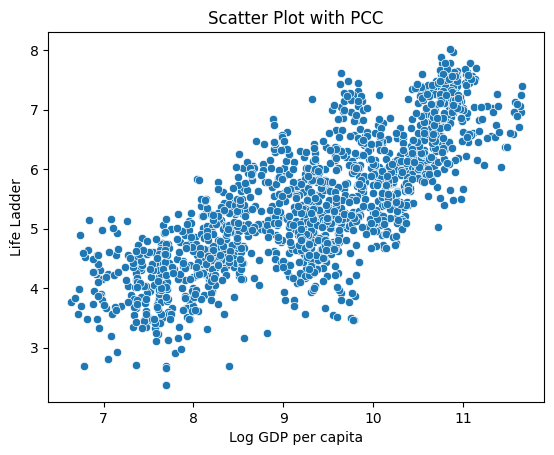

In [5]:
sns.scatterplot(x='Log GDP per capita', y='Life Ladder', data=data)
plt.title("Scatter Plot with PCC")
plt.show()

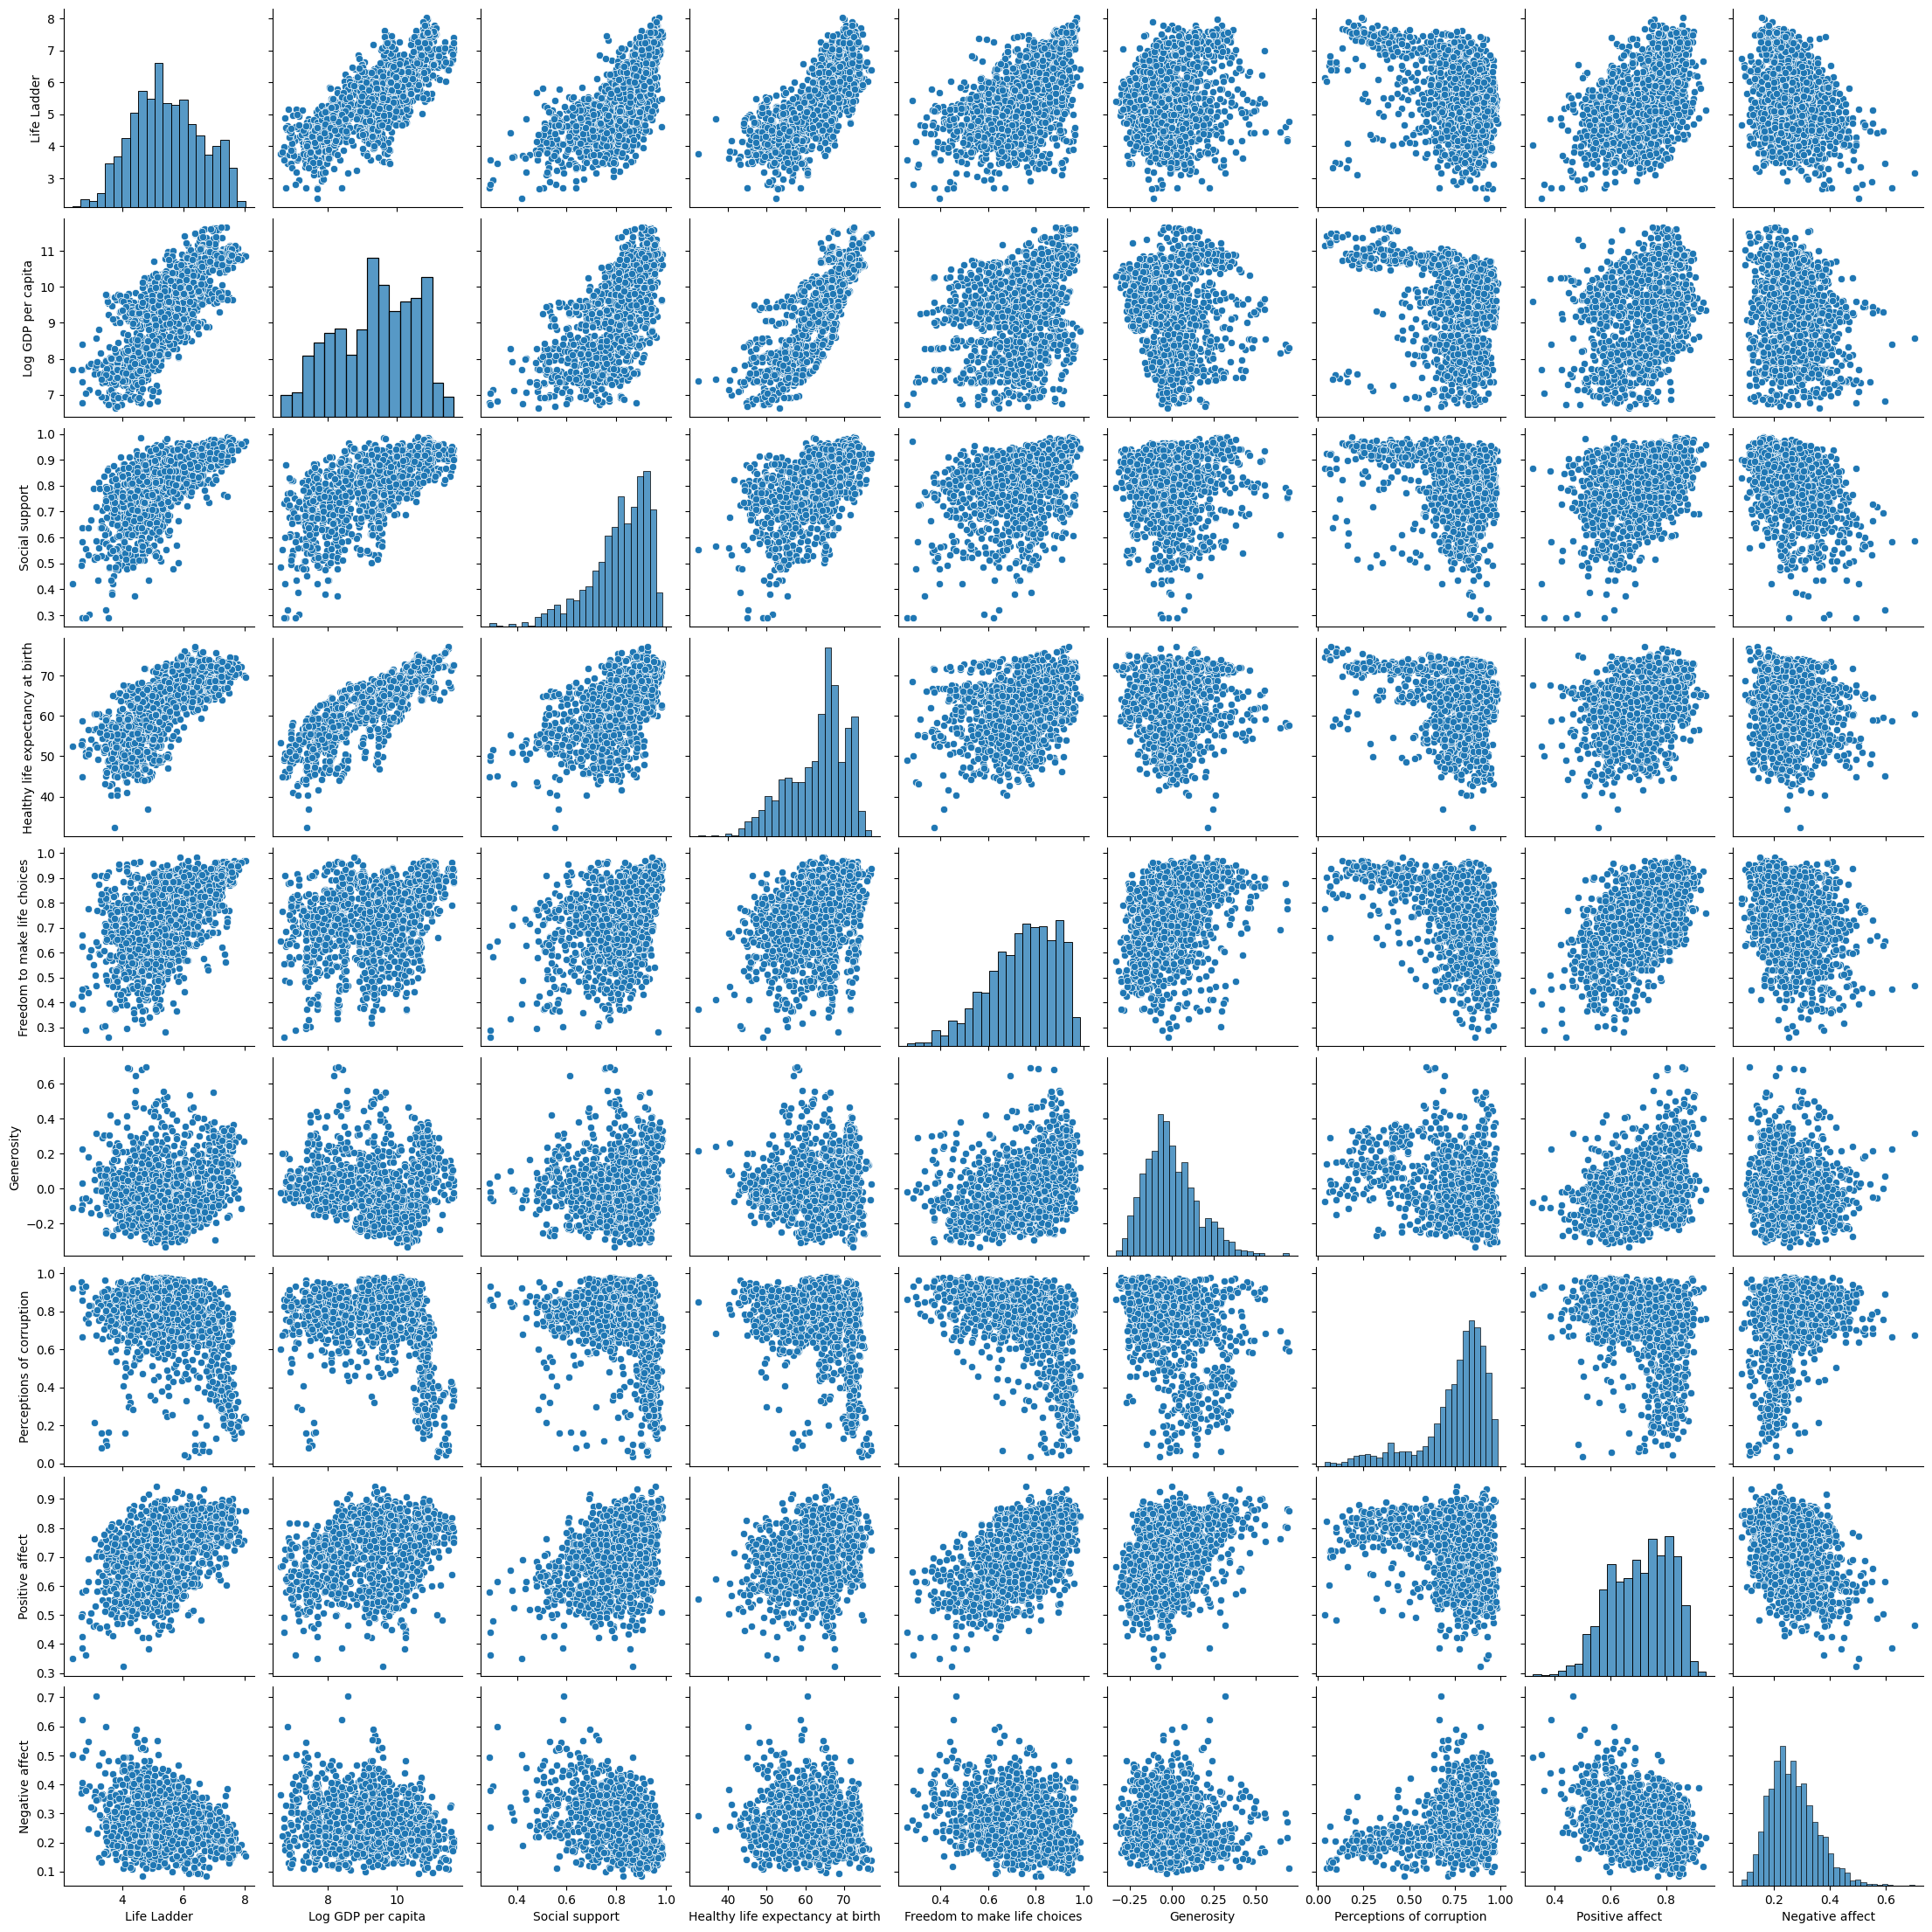

In [6]:
sns.pairplot(data[['Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth'   ,                       
'Freedom to make life choices',
'Generosity',
'Perceptions of corruption',
'Positive affect',
'Negative affect']])
plt.show()

Answer C:
It can be said by looking at PCC and scatter plot that :
Life Ladder is strongly related with Log GDP/Capita, social support, healthy life expectancy, freedom of make life choice. It is also weekly related with prerception of corruption, negative affect.

It is safe to say that cells corresponding to oranages and reds have strong correlation between the corresponding features. 
But Blue and grey cells have less correlation between the corresponding feature.


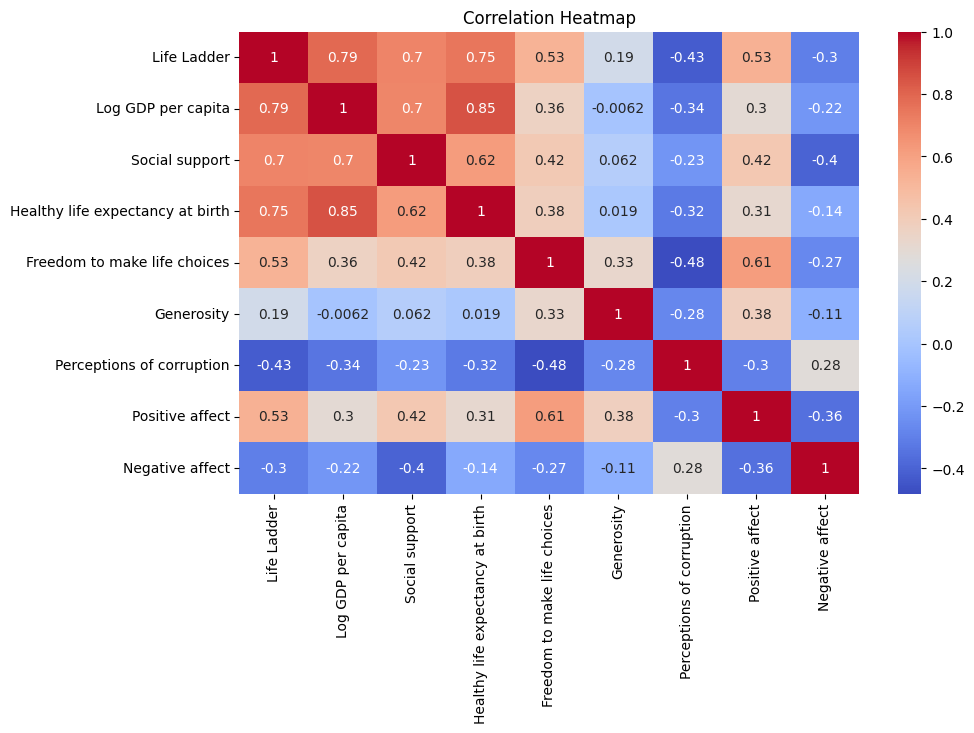

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Part D starts here:
-

In [8]:
RANDOM_SEED = 30
np.random.seed(RANDOM_SEED)

In [9]:
target_col = 'Life Ladder'
X = data.drop(columns=[target_col])
y = data[target_col]


In [10]:
valid_idx = ~y.isnull()
X = X[valid_idx]
y = y[valid_idx]   # drop null code, not necessary

In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print(f"\nAfter handling missing values:")
print(f"Dataset shape: {X.shape}")
print(f"Features used: {list(X.columns)}")
print(f"Target variable: {target_col}")


After handling missing values:
Dataset shape: (1559, 8)
Features used: ['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']
Target variable: Life Ladder


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
kfold = KFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

print("\n" + "="*80)
print("PART 1: CLOSED-FORM SOLUTIONS")
print("="*80)


PART 1: CLOSED-FORM SOLUTIONS


In [14]:
print("\n1. Linear Regression (Normal Equation/SVD)")
lr_model = LinearRegression()
cv_scores = cross_val_score(lr_model, X_scaled, y, cv=kfold, 
                            scoring='neg_root_mean_squared_error')
cv_rmse = -cv_scores
print(f"   Cross-validation RMSE scores: {cv_rmse}")
print(f"   Mean CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")


1. Linear Regression (Normal Equation/SVD)
   Cross-validation RMSE scores: [0.50655203 0.54872898 0.56828078 0.57072328]
   Mean CV RMSE: 0.5486 (+/- 0.0257)


In [15]:
lr_model.fit(X_scaled, y)
y_pred_lr = lr_model.predict(X_scaled)
train_rmse_lr = np.sqrt(mean_squared_error(y, y_pred_lr))
train_r2_lr = r2_score(y, y_pred_lr)
print(f"   Training RMSE: {train_rmse_lr:.4f}")
print(f"   Training R²: {train_r2_lr:.4f}")

print("\n" + "="*80)
print("PART 2: SGD WITHOUT REGULARIZATION")
print("="*80)

   Training RMSE: 0.5454
   Training R²: 0.7598

PART 2: SGD WITHOUT REGULARIZATION


In [16]:
print("\n2. SGD Linear Regression (No Regularization)")
sgd_model = SGDRegressor(penalty=None, max_iter=1000, tol=1e-3, 
                         random_state=RANDOM_SEED, learning_rate='invscaling',
                         eta0=0.01)
cv_scores_sgd = cross_val_score(sgd_model, X_scaled, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error')
cv_rmse_sgd = -cv_scores_sgd
print(f"   Cross-validation RMSE scores: {cv_rmse_sgd}")
print(f"   Mean CV RMSE: {cv_rmse_sgd.mean():.4f} (+/- {cv_rmse_sgd.std():.4f})")

print("\n" + "="*80)
print("PART 3: REGULARIZATION EXPERIMENTS")
print("="*80)


2. SGD Linear Regression (No Regularization)
   Cross-validation RMSE scores: [0.50773048 0.54979493 0.56585417 0.57061505]
   Mean CV RMSE: 0.5485 (+/- 0.0248)

PART 3: REGULARIZATION EXPERIMENTS


In [17]:
print("\n3. Ridge Regularization (L2)")
alpha_values = [0.01, 1.0, 100.0]
ridge_results = {}

for alpha in alpha_values:
    sgd_ridge = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000, 
                             tol=1e-3, random_state=RANDOM_SEED, 
                             learning_rate='invscaling', eta0=0.01)
    cv_scores = cross_val_score(sgd_ridge, X_scaled, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    ridge_results[alpha] = cv_rmse.mean()
    print(f"   Alpha={alpha:6.2f}: CV RMSE = {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")



3. Ridge Regularization (L2)
   Alpha=  0.01: CV RMSE = 0.5485 (+/- 0.0248)
   Alpha=  1.00: CV RMSE = 0.5963 (+/- 0.0290)
   Alpha=100.00: CV RMSE = 1.0874 (+/- 0.0143)


In [18]:
print("\n4. Lasso Regularization (L1)")
lasso_results = {}

for alpha in alpha_values:
    sgd_lasso = SGDRegressor(penalty='l1', alpha=alpha, max_iter=1000, 
                             tol=1e-3, random_state=RANDOM_SEED,
                             learning_rate='invscaling', eta0=0.01)
    cv_scores = cross_val_score(sgd_lasso, X_scaled, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    lasso_results[alpha] = cv_rmse.mean()
    print(f"   Alpha={alpha:6.2f}: CV RMSE = {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")


4. Lasso Regularization (L1)
   Alpha=  0.01: CV RMSE = 0.5487 (+/- 0.0251)
   Alpha=  1.00: CV RMSE = 1.1133 (+/- 0.0082)
   Alpha=100.00: CV RMSE = 1.1133 (+/- 0.0082)


In [19]:
print("\n5. Elastic Net Regularization (L1 + L2, l1_ratio=0.5)")
elasticnet_results = {}

for alpha in alpha_values:
    sgd_elastic = SGDRegressor(penalty='elasticnet', alpha=alpha, l1_ratio=0.5,
                               max_iter=1000, tol=1e-3, random_state=RANDOM_SEED,
                               learning_rate='invscaling', eta0=0.01)
    cv_scores = cross_val_score(sgd_elastic, X_scaled, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    elasticnet_results[alpha] = cv_rmse.mean()
    print(f"   Alpha={alpha:6.2f}: CV RMSE = {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")




5. Elastic Net Regularization (L1 + L2, l1_ratio=0.5)
   Alpha=  0.01: CV RMSE = 0.5486 (+/- 0.0250)
   Alpha=  1.00: CV RMSE = 0.8782 (+/- 0.0058)
   Alpha=100.00: CV RMSE = 1.1133 (+/- 0.0082)


In [20]:
print("\n" + "="*80)
print("PART 4: HYPERPARAMETER EXPLORATION - LEARNING RATE")
print("="*80)


PART 4: HYPERPARAMETER EXPLORATION - LEARNING RATE


In [21]:
print("\n6. Impact of Learning Rate (with Ridge, alpha=1.0)")
learning_rates = [0.001, 0.01, 0.1]
lr_results = {}

for lr in learning_rates:
    sgd_lr = SGDRegressor(penalty='l2', alpha=1.0, max_iter=1000, tol=1e-3,
                          random_state=RANDOM_SEED, learning_rate='constant', 
                          eta0=lr)
    cv_scores = cross_val_score(sgd_lr, X_scaled, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    lr_results[lr] = cv_rmse.mean()
    print(f"   Learning Rate={lr:.4f}: CV RMSE = {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

print("\n   Impact: Lower learning rates converge slowly but more stably.")
print("           Higher learning rates converge faster but may overshoot or diverge.")

print("\n7. Impact of Learning Rate Schedule (with Ridge, alpha=1.0, eta0=0.01)")
schedules = ['constant', 'optimal', 'invscaling', 'adaptive']
schedule_results = {}

for schedule in schedules:
    sgd_schedule = SGDRegressor(penalty='l2', alpha=1.0, max_iter=1000, tol=1e-3,
                                random_state=RANDOM_SEED, learning_rate=schedule, 
                                eta0=0.01)
    cv_scores = cross_val_score(sgd_schedule, X_scaled, y, cv=kfold, 
                                scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores
    schedule_results[schedule] = cv_rmse.mean()
    print(f"   Schedule={schedule:12s}: CV RMSE = {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

print("\n   Impact: Different schedules affect convergence speed and final performance.")
print("           'optimal' and 'invscaling' typically work well for most problems.")



6. Impact of Learning Rate (with Ridge, alpha=1.0)
   Learning Rate=0.0010: CV RMSE = 0.6003 (+/- 0.0228)
   Learning Rate=0.0100: CV RMSE = 0.6140 (+/- 0.0434)
   Learning Rate=0.1000: CV RMSE = 0.7090 (+/- 0.1281)

   Impact: Lower learning rates converge slowly but more stably.
           Higher learning rates converge faster but may overshoot or diverge.

7. Impact of Learning Rate Schedule (with Ridge, alpha=1.0, eta0=0.01)
   Schedule=constant    : CV RMSE = 0.6140 (+/- 0.0434)
   Schedule=optimal     : CV RMSE = 0.5986 (+/- 0.0241)
   Schedule=invscaling  : CV RMSE = 0.5963 (+/- 0.0290)
   Schedule=adaptive    : CV RMSE = 0.5988 (+/- 0.0244)

   Impact: Different schedules affect convergence speed and final performance.
           'optimal' and 'invscaling' typically work well for most problems.


In [22]:
print("\n" + "="*80)
print("PART 5: SUMMARY AND BEST MODEL SELECTION")
print("="*80)



PART 5: SUMMARY AND BEST MODEL SELECTION


In [23]:
all_results = {
    'Linear Regression': cv_rmse.mean(),
    'SGD (no reg)': cv_rmse_sgd.mean(),
}

for alpha in alpha_values:
    all_results[f'Ridge (α={alpha})'] = ridge_results[alpha]
    all_results[f'Lasso (α={alpha})'] = lasso_results[alpha]
    all_results[f'ElasticNet (α={alpha})'] = elasticnet_results[alpha]

print("\nAll Model Performance (CV RMSE):")
for model_name, rmse in sorted(all_results.items(), key=lambda x: x[1]):
    print(f"   {model_name:30s}: {rmse:.4f}")


All Model Performance (CV RMSE):
   Ridge (α=0.01)                : 0.5485
   SGD (no reg)                  : 0.5485
   ElasticNet (α=0.01)           : 0.5486
   Lasso (α=0.01)                : 0.5487
   Ridge (α=1.0)                 : 0.5963
   Linear Regression             : 0.5988
   ElasticNet (α=1.0)            : 0.8782
   Ridge (α=100.0)               : 1.0874
   Lasso (α=100.0)               : 1.1133
   ElasticNet (α=100.0)          : 1.1133
   Lasso (α=1.0)                 : 1.1133


In [24]:
best_model_name = min(all_results, key=all_results.get)
best_rmse = all_results[best_model_name]
print(f"\nBest Model: {best_model_name} with CV RMSE = {best_rmse:.4f}")

# Determine best hyperparameters
if 'Ridge' in best_model_name:
    best_penalty = 'l2'
    best_alpha = float(best_model_name.split('α=')[1].rstrip(')'))
elif 'Lasso' in best_model_name:
    best_penalty = 'l1'
    best_alpha = float(best_model_name.split('α=')[1].rstrip(')'))
elif 'ElasticNet' in best_model_name:
    best_penalty = 'elasticnet'
    best_alpha = float(best_model_name.split('α=')[1].rstrip(')'))
else:
    best_penalty = None
    best_alpha = 0.0001

print("\n" + "="*80)
print("PART 6: TRAINING BEST MODEL WITH EPOCH-BY-EPOCH TRACKING")
print("="*80)

# Train best model with epoch tracking
print(f"\nTraining best model: {best_model_name}")
print("Tracking training and validation loss by epoch...\n")

# Split data for validation tracking
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_SEED
)


Best Model: Ridge (α=0.01) with CV RMSE = 0.5485

PART 6: TRAINING BEST MODEL WITH EPOCH-BY-EPOCH TRACKING

Training best model: Ridge (α=0.01)
Tracking training and validation loss by epoch...



In [25]:
if best_penalty == 'elasticnet':
    best_sgd_model = SGDRegressor(
        penalty=best_penalty, alpha=best_alpha, l1_ratio=0.5,
        max_iter=1, warm_start=True, random_state=RANDOM_SEED,
        learning_rate='invscaling', eta0=0.01, tol=None
    )
else:
    best_sgd_model = SGDRegressor(
        penalty=best_penalty, alpha=best_alpha,
        max_iter=1, warm_start=True, random_state=RANDOM_SEED,
        learning_rate='invscaling', eta0=0.01, tol=None
    )

In [26]:
n_epochs = 100
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    best_sgd_model.fit(X_train, y_train)
    
    # Compute training and validation RMSE
    y_train_pred = best_sgd_model.predict(X_train)
    y_val_pred = best_sgd_model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_losses.append(train_rmse)
    val_losses.append(val_rmse)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}: Train RMSE = {train_rmse:.4f}, Val RMSE = {val_rmse:.4f}")

Epoch  10: Train RMSE = 0.5549, Val RMSE = 0.5065
Epoch  20: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  30: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  40: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  50: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  60: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  70: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  80: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch  90: Train RMSE = 0.5549, Val RMSE = 0.5066
Epoch 100: Train RMSE = 0.5549, Val RMSE = 0.5066


In [27]:
print("\n\nTraining final model on entire training dataset...")
if best_penalty == 'elasticnet':
    final_model = SGDRegressor(
        penalty=best_penalty, alpha=best_alpha, l1_ratio=0.5,
        max_iter=100, random_state=RANDOM_SEED,
        learning_rate='invscaling', eta0=0.01, tol=1e-3
    )
else:
    final_model = SGDRegressor(
        penalty=best_penalty, alpha=best_alpha,
        max_iter=100, random_state=RANDOM_SEED,
        learning_rate='invscaling', eta0=0.01, tol=1e-3
    )

final_model.fit(X_scaled, y)
y_pred_final = final_model.predict(X_scaled)
final_rmse = np.sqrt(mean_squared_error(y, y_pred_final))
final_r2 = r2_score(y, y_pred_final)
final_mae = mean_absolute_error(y, y_pred_final)



Training final model on entire training dataset...


In [28]:
print(f"\nFinal Model Performance on Full Training Set:")
print(f"   RMSE: {final_rmse:.4f}")
print(f"   R²:   {final_r2:.4f}")
print(f"   MAE:  {final_mae:.4f}")

print("\n" + "="*80)
print("PART 7: VISUALIZATIONS")
print("="*80)



Final Model Performance on Full Training Set:
   RMSE: 0.5463
   R²:   0.7590
   MAE:  0.4238

PART 7: VISUALIZATIONS



Visualization saved as 'linear_regression_analysis.png'


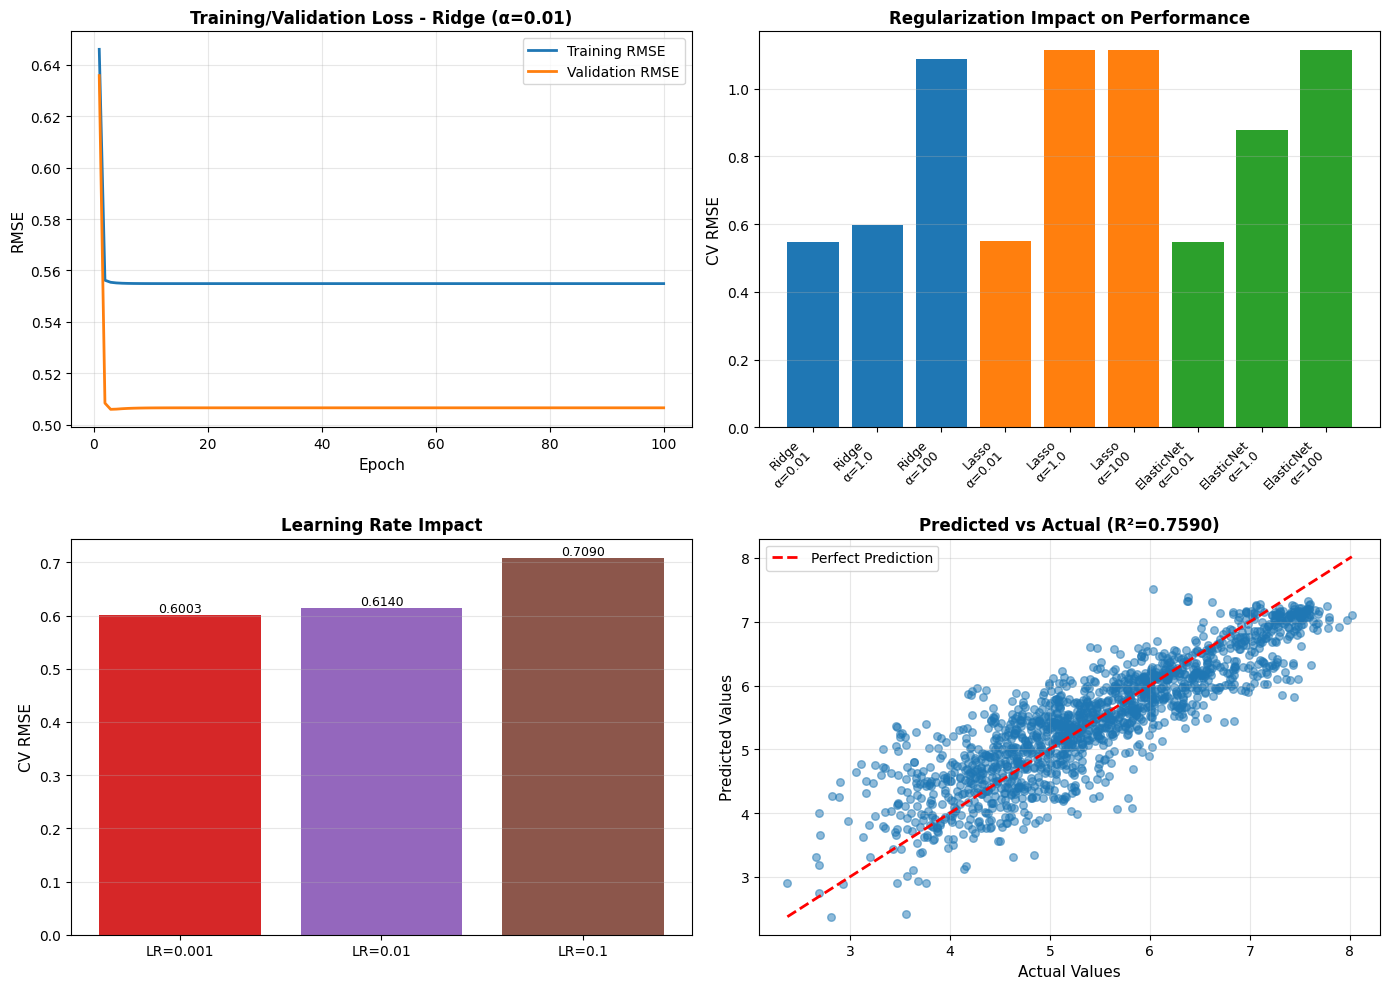


Best configuration: Ridge (α=0.01) with RMSE = 0.5485


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training and Validation Loss over Epochs
ax1 = axes[0, 0]
ax1.plot(range(1, n_epochs + 1), train_losses, label='Training RMSE', linewidth=2)
ax1.plot(range(1, n_epochs + 1), val_losses, label='Validation RMSE', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title(f'Training/Validation Loss - {best_model_name}', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Regularization Impact Comparison
ax2 = axes[0, 1]
reg_comparison = {
    'Ridge\nα=0.01': ridge_results[0.01],
    'Ridge\nα=1.0': ridge_results[1.0],
    'Ridge\nα=100': ridge_results[100.0],
    'Lasso\nα=0.01': lasso_results[0.01],
    'Lasso\nα=1.0': lasso_results[1.0],
    'Lasso\nα=100': lasso_results[100.0],
    'ElasticNet\nα=0.01': elasticnet_results[0.01],
    'ElasticNet\nα=1.0': elasticnet_results[1.0],
    'ElasticNet\nα=100': elasticnet_results[100.0],
}
colors = ['#1f77b4']*3 + ['#ff7f0e']*3 + ['#2ca02c']*3
bars = ax2.bar(range(len(reg_comparison)), list(reg_comparison.values()), color=colors)
ax2.set_xticks(range(len(reg_comparison)))
ax2.set_xticklabels(list(reg_comparison.keys()), rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('CV RMSE', fontsize=11)
ax2.set_title('Regularization Impact on Performance', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Learning Rate Impact
ax3 = axes[1, 0]
lr_names = [f'LR={lr}' for lr in learning_rates]
bars = ax3.bar(lr_names, [lr_results[lr] for lr in learning_rates], 
               color=['#d62728', '#9467bd', '#8c564b'])
ax3.set_ylabel('CV RMSE', fontsize=11)
ax3.set_title('Learning Rate Impact', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for i, (lr, rmse) in enumerate(lr_results.items()):
    ax3.text(i, rmse, f'{rmse:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Predicted vs Actual
ax4 = axes[1, 1]
ax4.scatter(y, y_pred_final, alpha=0.5, s=30)
min_val = min(y.min(), y_pred_final.min())
max_val = max(y.max(), y_pred_final.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Values', fontsize=11)
ax4.set_ylabel('Predicted Values', fontsize=11)
ax4.set_title(f'Predicted vs Actual (R²={final_r2:.4f})', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('linear_regression_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'linear_regression_analysis.png'")
plt.show()

print(f"\nBest configuration: {best_model_name} with RMSE = {best_rmse:.4f}")

Solution of E starts here.
---------------------------------------------------------------------------------------


Testing polynomial degrees [1, 2, 3, 4, 5]...
--------------------------------------------------------------------------------

Degree 1:
  Number of polynomial features: 8
  Train RMSE: 0.5560 | Val RMSE: 0.5091
  Train R²:   0.7502 | Val R²:   0.7911
  Gap (Val-Train RMSE): -0.0468

Degree 2:
  Number of polynomial features: 44
  Train RMSE: 0.4999 | Val RMSE: 0.4929
  Train R²:   0.7981 | Val R²:   0.8042
  Gap (Val-Train RMSE): -0.0069

Degree 3:
  Number of polynomial features: 164
  Train RMSE: 827.6986 | Val RMSE: 734.9670
  Train R²:   -553695.2339 | Val R²:   -435337.3450
  Gap (Val-Train RMSE): -92.7316

Degree 4:
  Number of polynomial features: 494
  Train RMSE: 796024722480.5966 | Val RMSE: 1163661749190.4272
  Train R²:   -512129974479686029279232.0000 | Val R²:   -1091301415382701412712448.0000
  Gap (Val-Train RMSE): 367637026709.8307

Degree 5:
  Number of polynomial features: 1286
  Train RMSE: 1579392186488.5076 | Val RMSE: 1831057506969.8611
  Train R²:   -20160767

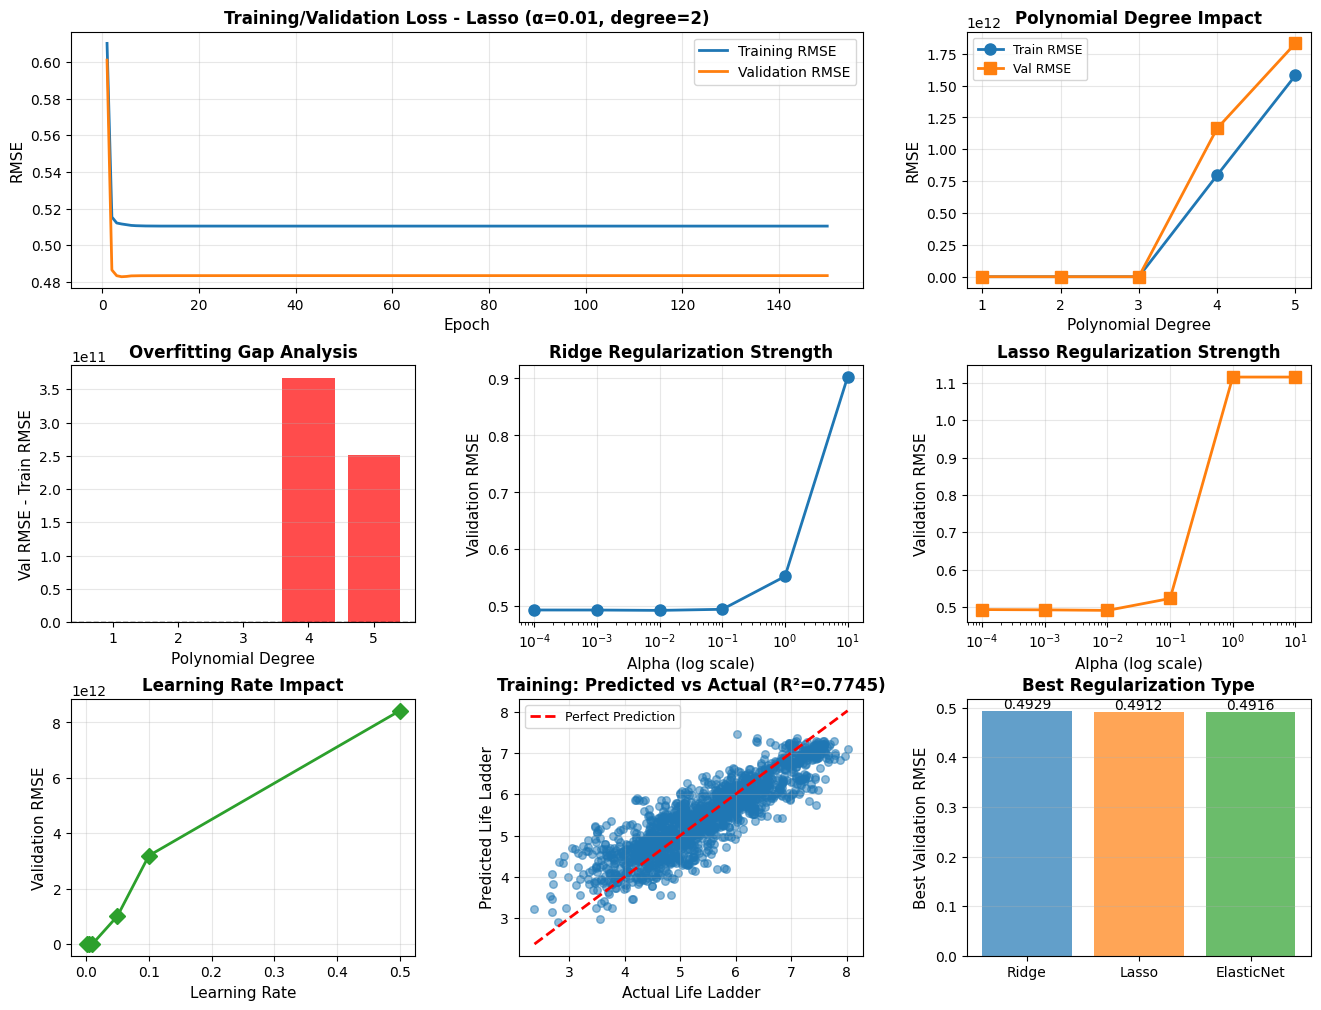

In [34]:
degrees = [1, 2, 3, 4, 5]
degree_results = {}

print("\nTesting polynomial degrees [1, 2, 3, 4, 5]...")
print("-" * 80)

for degree in degrees:
    print(f"\nDegree {degree}:")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)
    
    # Standardize
    scaler = StandardScaler()
    X_poly_train_scaled = scaler.fit_transform(X_poly_train)
    X_poly_val_scaled = scaler.transform(X_poly_val)
    
    print(f"  Number of polynomial features: {X_poly_train_scaled.shape[1]}")
    
    # Train SGD model
    sgd_model = SGDRegressor(
        penalty='l2', alpha=0.01, max_iter=1000, tol=1e-3,
        random_state=RANDOM_SEED, learning_rate='invscaling', eta0=0.01
    )
    sgd_model.fit(X_poly_train_scaled, y_train)
    
    # Predictions
    y_train_pred = sgd_model.predict(X_poly_train_scaled)
    y_val_pred = sgd_model.predict(X_poly_val_scaled)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    degree_results[degree] = {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'n_features': X_poly_train_scaled.shape[1]
    }
    
    print(f"  Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Val R²:   {val_r2:.4f}")
    print(f"  Gap (Val-Train RMSE): {val_rmse - train_rmse:.4f}")

print("\n" + "="*80)
print("3. OVERFITTING/UNDERFITTING ANALYSIS")
print("="*80)

print("\nAnalyzing model fit based on train-validation gap:\n")
for degree, metrics in degree_results.items():
    gap = metrics['val_rmse'] - metrics['train_rmse']
    gap_pct = (gap / metrics['train_rmse']) * 100
    
    print(f"Degree {degree}:")
    print(f"  Train RMSE: {metrics['train_rmse']:.4f}")
    print(f"  Val RMSE:   {metrics['val_rmse']:.4f}")
    print(f"  Gap:        {gap:.4f} ({gap_pct:.1f}%)")
    
    
print("\nKEY FINDINGS:")
print("-" * 80)
best_val_degree = min(degree_results.keys(), key=lambda d: degree_results[d]['val_rmse'])
print(f"• Best validation RMSE at degree {best_val_degree}: {degree_results[best_val_degree]['val_rmse']:.4f}")
print(f"• Degree 1 (linear) baseline: {degree_results[1]['val_rmse']:.4f}")
print(f"• As degree increases, training error decreases but validation may increase")
print(f"• High-degree polynomials risk overfitting with {X.shape[1]} original features")

print("\n" + "="*80)
print("4. REGULARIZATION EXPERIMENTS WITH POLYNOMIAL FEATURES")
print("="*80)

# Use best polynomial degree for regularization experiments
print(f"\nUsing polynomial degree {best_val_degree} for detailed experiments...")
print("-" * 80)

poly = PolynomialFeatures(degree=best_val_degree, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_val = poly.transform(X_val)

scaler = StandardScaler()
X_poly_train_scaled = scaler.fit_transform(X_poly_train)
X_poly_val_scaled = scaler.transform(X_poly_val)

# Test different regularization types and strengths
regularization_experiments = []
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

print("\n4.1 Ridge Regularization (L2)")
for alpha in alpha_values:
    sgd = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000, tol=1e-3,
                       random_state=RANDOM_SEED, learning_rate='invscaling', eta0=0.01)
    sgd.fit(X_poly_train_scaled, y_train)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_poly_train_scaled)))
    val_rmse = np.sqrt(mean_squared_error(y_val, sgd.predict(X_poly_val_scaled)))
    
    regularization_experiments.append({
        'type': 'Ridge',
        'alpha': alpha,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    })
    print(f"  α={alpha:7.4f}: Train={train_rmse:.4f}, Val={val_rmse:.4f}, Gap={val_rmse-train_rmse:.4f}")

print("\n4.2 Lasso Regularization (L1)")
for alpha in alpha_values:
    sgd = SGDRegressor(penalty='l1', alpha=alpha, max_iter=1000, tol=1e-3,
                       random_state=RANDOM_SEED, learning_rate='invscaling', eta0=0.01)
    sgd.fit(X_poly_train_scaled, y_train)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_poly_train_scaled)))
    val_rmse = np.sqrt(mean_squared_error(y_val, sgd.predict(X_poly_val_scaled)))
    
    regularization_experiments.append({
        'type': 'Lasso',
        'alpha': alpha,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    })
    print(f"  α={alpha:7.4f}: Train={train_rmse:.4f}, Val={val_rmse:.4f}, Gap={val_rmse-train_rmse:.4f}")

print("\n4.3 Elastic Net Regularization (L1 + L2)")
for alpha in alpha_values:
    sgd = SGDRegressor(penalty='elasticnet', alpha=alpha, l1_ratio=0.5,
                       max_iter=1000, tol=1e-3, random_state=RANDOM_SEED,
                       learning_rate='invscaling', eta0=0.01)
    sgd.fit(X_poly_train_scaled, y_train)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_poly_train_scaled)))
    val_rmse = np.sqrt(mean_squared_error(y_val, sgd.predict(X_poly_val_scaled)))
    
    regularization_experiments.append({
        'type': 'ElasticNet',
        'alpha': alpha,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    })
    print(f"  α={alpha:7.4f}: Train={train_rmse:.4f}, Val={val_rmse:.4f}, Gap={val_rmse-train_rmse:.4f}")

print("\n" + "="*80)
print("5. LEARNING RATE EXPLORATION")
print("="*80)

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
lr_results = []

print(f"\nTesting learning rates with Ridge (α=0.01), degree={best_val_degree}:")
print("-" * 80)

for lr in learning_rates:
    sgd = SGDRegressor(penalty='l2', alpha=0.01, max_iter=1000, tol=1e-3,
                       random_state=RANDOM_SEED, learning_rate='constant', eta0=lr)
    sgd.fit(X_poly_train_scaled, y_train)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, sgd.predict(X_poly_train_scaled)))
    val_rmse = np.sqrt(mean_squared_error(y_val, sgd.predict(X_poly_val_scaled)))
    
    lr_results.append({
        'lr': lr,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse
    })
    print(f"  LR={lr:.4f}: Train={train_rmse:.4f}, Val={val_rmse:.4f}")

print("\n" + "="*80)
print("6. BEST MODEL SELECTION")
print("="*80)

# Find best configuration
best_config = min(regularization_experiments, key=lambda x: x['val_rmse'])
print(f"\nBest configuration based on validation RMSE:")
print(f"  Regularization: {best_config['type']}")
print(f"  Alpha: {best_config['alpha']}")
print(f"  Polynomial Degree: {best_val_degree}")
print(f"  Validation RMSE: {best_config['val_rmse']:.4f}")
print(f"  Training RMSE: {best_config['train_rmse']:.4f}")

print("\n" + "="*80)
print("7. TRAINING BEST MODEL WITH EPOCH TRACKING")
print("="*80)

print("\nTraining best model with epoch-by-epoch tracking...")

# Prepare polynomial features for best degree
poly_best = PolynomialFeatures(degree=best_val_degree, include_bias=False)
X_poly_train = poly_best.fit_transform(X_train)
X_poly_val = poly_best.transform(X_val)

scaler_best = StandardScaler()
X_poly_train_scaled = scaler_best.fit_transform(X_poly_train)
X_poly_val_scaled = scaler_best.transform(X_poly_val)

# Initialize best model
if best_config['type'] == 'Ridge':
    best_model = SGDRegressor(penalty='l2', alpha=best_config['alpha'],
                              max_iter=1, warm_start=True, tol=None,
                              random_state=RANDOM_SEED, learning_rate='invscaling', eta0=0.01)
elif best_config['type'] == 'Lasso':
    best_model = SGDRegressor(penalty='l1', alpha=best_config['alpha'],
                              max_iter=1, warm_start=True, tol=None,
                              random_state=RANDOM_SEED, learning_rate='invscaling', eta0=0.01)
else:  # ElasticNet
    best_model = SGDRegressor(penalty='elasticnet', alpha=best_config['alpha'], l1_ratio=0.5,
                              max_iter=1, warm_start=True, tol=None,
                              random_state=RANDOM_SEED, learning_rate='invscaling', eta0=0.01)

# Track losses over epochs
n_epochs = 150
train_losses_epoch = []
val_losses_epoch = []

for epoch in range(n_epochs):
    best_model.fit(X_poly_train_scaled, y_train)
    
    y_train_pred = best_model.predict(X_poly_train_scaled)
    y_val_pred = best_model.predict(X_poly_val_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    train_losses_epoch.append(train_rmse)
    val_losses_epoch.append(val_rmse)
    
    if (epoch + 1) % 30 == 0:
        print(f"Epoch {epoch+1:3d}: Train RMSE={train_rmse:.4f}, Val RMSE={val_rmse:.4f}")

print("\n" + "="*80)
print("8. FINAL MODEL TRAINING ON FULL TRAINING SET")
print("="*80)

# Train on full training data with best hyperparameters
print("\nTraining final model on entire training dataset...")

# Prepare full training data
X_full = X  # All training data
y_full = y

poly_final = PolynomialFeatures(degree=best_val_degree, include_bias=False)
X_poly_full = poly_final.fit_transform(X_full)

scaler_final = StandardScaler()
X_poly_full_scaled = scaler_final.fit_transform(X_poly_full)

# Train final model
if best_config['type'] == 'Ridge':
    final_model = SGDRegressor(penalty='l2', alpha=best_config['alpha'],
                               max_iter=150, tol=1e-3, random_state=RANDOM_SEED,
                               learning_rate='invscaling', eta0=0.01)
elif best_config['type'] == 'Lasso':
    final_model = SGDRegressor(penalty='l1', alpha=best_config['alpha'],
                               max_iter=150, tol=1e-3, random_state=RANDOM_SEED,
                               learning_rate='invscaling', eta0=0.01)
else:  # ElasticNet
    final_model = SGDRegressor(penalty='elasticnet', alpha=best_config['alpha'], l1_ratio=0.5,
                               max_iter=150, tol=1e-3, random_state=RANDOM_SEED,
                               learning_rate='invscaling', eta0=0.01)

final_model.fit(X_poly_full_scaled, y_full)

# Evaluate on training set
y_pred_train_final = final_model.predict(X_poly_full_scaled)
final_train_rmse = np.sqrt(mean_squared_error(y_full, y_pred_train_final))
final_train_r2 = r2_score(y_full, y_pred_train_final)
final_train_mae = mean_absolute_error(y_full, y_pred_train_final)

print(f"\nFinal Model Performance on Full Training Set:")
print(f"  RMSE: {final_train_rmse:.4f}")
print(f"  R²:   {final_train_r2:.4f}")
print(f"  MAE:  {final_train_mae:.4f}")

print("\n" + "="*80)
print("9. TEST SET PREDICTIONS")
print("="*80)

# Load test data
try:
    test_data = pd.read_csv('happiness_data_test.csv')
    print(f"\nTest dataset loaded successfully!")
    print(f"Test dataset shape: {test_data.shape}")
    
    # Check if test has target column (for evaluation) or not
    has_test_target = target_col in test_data.columns
    
    if has_test_target:
        X_test = test_data.drop(columns=[target_col])
        y_test = test_data[target_col]
        print(f"Test set has target variable for evaluation")
    else:
        X_test = test_data
        y_test = None
        print(f"Test set does not have target variable (blind test)")
    
    # Impute missing values in test set using same imputer
    X_test_imputed = imputer.transform(X_test)
    X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)
    
    # Apply polynomial features and scaling
    X_test_poly = poly_final.transform(X_test)
    X_test_poly_scaled = scaler_final.transform(X_test_poly)
    
    # Make predictions
    y_test_pred = final_model.predict(X_test_poly_scaled)
    
    print(f"\nPredictions generated for {len(y_test_pred)} test samples")
    print(f"Prediction statistics:")
    print(f"  Mean: {y_test_pred.mean():.4f}")
    print(f"  Std:  {y_test_pred.std():.4f}")
    print(f"  Min:  {y_test_pred.min():.4f}")
    print(f"  Max:  {y_test_pred.max():.4f}")
    
    # If test has labels, calculate test RMSE
    if has_test_target and y_test is not None:
        # Remove any NaN values in test target
        valid_test_idx = ~y_test.isnull()
        y_test_clean = y_test[valid_test_idx]
        y_test_pred_clean = y_test_pred[valid_test_idx]
        
        test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_clean))
        test_r2 = r2_score(y_test_clean, y_test_pred_clean)
        test_mae = mean_absolute_error(y_test_clean, y_test_pred_clean)
        
        print(f"\n{'='*80}")
        print("TEST SET PERFORMANCE (OFFICIAL SCORE)")
        print(f"{'='*80}")
        print(f"  TEST RMSE: {test_rmse:.4f} ⭐")
        print(f"  TEST R²:   {test_r2:.4f}")
        print(f"  TEST MAE:  {test_mae:.4f}")
        print(f"{'='*80}")
    
    # Save predictions
    predictions_df = pd.DataFrame({
        'Predicted_Life_Ladder': y_test_pred
    })
    predictions_df.to_csv('test_predictions.csv', index=False)
    
except FileNotFoundError:
    print("\n⚠ Warning: 'happiness_data_test.csv' not found")
    print("Please ensure the test file is in the same directory")

print("\n" + "="*80)
print("10. VISUALIZATIONS")
print("="*80)

# Create comprehensive visualizations
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Training and Validation Loss over Epochs
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(range(1, n_epochs + 1), train_losses_epoch, label='Training RMSE', linewidth=2, color='#1f77b4')
ax1.plot(range(1, n_epochs + 1), val_losses_epoch, label='Validation RMSE', linewidth=2, color='#ff7f0e')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('RMSE', fontsize=11)
ax1.set_title(f'Training/Validation Loss - {best_config["type"]} (α={best_config["alpha"]}, degree={best_val_degree})', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Polynomial Degree Impact
ax2 = fig.add_subplot(gs[0, 2])
degrees_list = list(degree_results.keys())
train_rmses = [degree_results[d]['train_rmse'] for d in degrees_list]
val_rmses = [degree_results[d]['val_rmse'] for d in degrees_list]
ax2.plot(degrees_list, train_rmses, 'o-', label='Train RMSE', linewidth=2, markersize=8)
ax2.plot(degrees_list, val_rmses, 's-', label='Val RMSE', linewidth=2, markersize=8)
ax2.set_xlabel('Polynomial Degree', fontsize=11)
ax2.set_ylabel('RMSE', fontsize=11)
ax2.set_title('Polynomial Degree Impact', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(degrees_list)

# Plot 3: Overfitting Analysis (Gap)
ax3 = fig.add_subplot(gs[1, 0])
gaps = [degree_results[d]['val_rmse'] - degree_results[d]['train_rmse'] for d in degrees_list]
colors_gap = ['green' if g < 0.05 else 'orange' if g < 0.15 else 'red' for g in gaps]
bars = ax3.bar(degrees_list, gaps, color=colors_gap, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Polynomial Degree', fontsize=11)
ax3.set_ylabel('Val RMSE - Train RMSE', fontsize=11)
ax3.set_title('Overfitting Gap Analysis', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(degrees_list)

# Plot 4: Regularization Comparison (Ridge)
ax4 = fig.add_subplot(gs[1, 1])
ridge_exps = [e for e in regularization_experiments if e['type'] == 'Ridge']
alphas_ridge = [e['alpha'] for e in ridge_exps]
val_rmses_ridge = [e['val_rmse'] for e in ridge_exps]
ax4.semilogx(alphas_ridge, val_rmses_ridge, 'o-', linewidth=2, markersize=8, color='#1f77b4')
ax4.set_xlabel('Alpha (log scale)', fontsize=11)
ax4.set_ylabel('Validation RMSE', fontsize=11)
ax4.set_title('Ridge Regularization Strength', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Regularization Comparison (Lasso)
ax5 = fig.add_subplot(gs[1, 2])
lasso_exps = [e for e in regularization_experiments if e['type'] == 'Lasso']
alphas_lasso = [e['alpha'] for e in lasso_exps]
val_rmses_lasso = [e['val_rmse'] for e in lasso_exps]
ax5.semilogx(alphas_lasso, val_rmses_lasso, 's-', linewidth=2, markersize=8, color='#ff7f0e')
ax5.set_xlabel('Alpha (log scale)', fontsize=11)
ax5.set_ylabel('Validation RMSE', fontsize=11)
ax5.set_title('Lasso Regularization Strength', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Learning Rate Impact
ax6 = fig.add_subplot(gs[2, 0])
lrs = [r['lr'] for r in lr_results]
val_rmses_lr = [r['val_rmse'] for r in lr_results]
ax6.plot(lrs, val_rmses_lr, 'D-', linewidth=2, markersize=8, color='#2ca02c')
ax6.set_xlabel('Learning Rate', fontsize=11)
ax6.set_ylabel('Validation RMSE', fontsize=11)
ax6.set_title('Learning Rate Impact', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Plot 7: Predicted vs Actual (Training)
ax7 = fig.add_subplot(gs[2, 1])
ax7.scatter(y_full, y_pred_train_final, alpha=0.5, s=30, color='#1f77b4')
min_val = min(y_full.min(), y_pred_train_final.min())
max_val = max(y_full.max(), y_pred_train_final.max())
ax7.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax7.set_xlabel('Actual Life Ladder', fontsize=11)
ax7.set_ylabel('Predicted Life Ladder', fontsize=11)
ax7.set_title(f'Training: Predicted vs Actual (R²={final_train_r2:.4f})', fontsize=12, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# Plot 8: All Regularization Types Comparison
ax8 = fig.add_subplot(gs[2, 2])
ridge_best = min([e for e in regularization_experiments if e['type'] == 'Ridge'], key=lambda x: x['val_rmse'])
lasso_best = min([e for e in regularization_experiments if e['type'] == 'Lasso'], key=lambda x: x['val_rmse'])
elastic_best = min([e for e in regularization_experiments if e['type'] == 'ElasticNet'], key=lambda x: x['val_rmse'])

reg_types = ['Ridge', 'Lasso', 'ElasticNet']
best_rmses = [ridge_best['val_rmse'], lasso_best['val_rmse'], elastic_best['val_rmse']]
colors_reg = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax8.bar(reg_types, best_rmses, color=colors_reg, alpha=0.7)
ax8.set_ylabel('Best Validation RMSE', fontsize=11)
ax8.set_title('Best Regularization Type', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3, axis='y')
for i, (bar, rmse) in enumerate(zip(bars, best_rmses)):
    ax8.text(i, rmse, f'{rmse:.4f}', ha='center', va='bottom', fontsize=10)

plt.savefig('polynomial_regression_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
